# Machine Learning Pipeline with ADASYN





## Step 1: Import Libraries and Load Dataset

Very much similar to the previous workflows we start by importing pretty much the same libraries.
Libraries for data handling (`numpy`, `pandas`), machine learning (`sklearn`, `xgboost`), balancing imbalanced classes (`imblearn` with ADASYN), visualisation (`matplotlib`), and interpretability (`shap`).

The FluPRINT dataset is loaded from a CSV file and prepared for analysis.

---

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import log_loss
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
import joblib
import warnings
from sklearn.base import clone

In [2]:
# Define the path to the FluPRINT database CSV file
database = r"C:\Users\Dana\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint_cleaned.csv"

# Read the CSV file
fluprint_filtered = pd.read_csv(database)

## Step 2: Data Preprocessing

Same procedure as before
- Duplicate measurements per donor and feature are aggregated using the median to reduce noise.
- Data is reshaped from a long to a wide format, where each donor has one row and each feature is a column.
- The target variable (`vaccine_response`) is extracted per donor.
- Features with more than 90% missing values are dropped, ensuring modeling focuses on informative variables.

---

In [ ]:
# Step 1: Aggregate duplicated measurements by donor and feature (mean)
agg_df = fluprint_filtered.groupby(["donor_id", "name_formatted"], as_index=False)["data"].median()

# Step 2: Pivot to wide format - donors as rows, features as columns
X_features = agg_df.pivot(index="donor_id", columns="name_formatted", values="data")

# Extract vaccine_response per donor
y = fluprint_filtered.groupby("donor_id")["vaccine_response"].first()

# Align y to X_features indices (donor_ids)
y = y.loc[X_features.index]

# Print shape of the pivoted data
print(f"Pivoted data shape: {X_features.shape}")

# Step 3: Calculate missing data fraction and drop high-missingness features
missing_fraction = X_features.isnull().mean()
keep_features = missing_fraction[missing_fraction <= 0.90].index
X_filtered = X_features[keep_features]

print(f"Original feature count: {X_features.shape[1]}")
print(f"Filtered feature count (<=90% missing): {X_filtered.shape[1]}")

Pivoted data shape: (292, 3283)
Original feature count: 3283
Filtered feature count (<=90% missing): 407


## Step 3: Imputation and Pipeline Definition with ADASYN

- We define a helper function `get_imputer` to select an imputation strategy from mean, median, or iterative imputation (MI). No PMM or MissForest as these take longer to compute.
- For each imputation strategy, machine learning pipelines are created combining:
  - The chosen imputer,
  - Feature scaling (`StandardScaler`),
  - ADASYN oversampling to synthetically balance the minority class,
  - A classifier (Random Forest or XGBoost).
- Pipelines are implemented with `imblearn`'s `ImbPipeline` to integrate all transformations seamlessly.

---

In [ ]:
def get_imputer(strategy):
    """Returns the appropriate imputer for a given strategy."""
    if strategy == "mean":
        return SimpleImputer(strategy="mean")
    elif strategy == "median":
        return SimpleImputer(strategy="median")
    elif strategy == "mi":
        return IterativeImputer(max_iter=50, random_state=42)
    else:
        raise ValueError("Invalid imputation strategy provided.")

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines with ADASYN for each strategy ---
adasyn_pipelines = {
    "mean_rf": ImbPipeline([("imputer", get_imputer("mean")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "mean_xgb": ImbPipeline([("imputer", get_imputer("mean")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))]),
    "median_rf": ImbPipeline([("imputer", get_imputer("median")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "median_xgb": ImbPipeline([("imputer", get_imputer("median")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))]),
    "mi_rf": ImbPipeline([("imputer", get_imputer("mi")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    "mi_xgb": ImbPipeline([("imputer", get_imputer("mi")), ("scaler", StandardScaler()), ("adasyn", ADASYN(random_state=42)), ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=1))])
}

# Dictionary to store results, now for the ADASYN experiment
adasyn_results = {
    "mean": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "median": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "mi": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []}
}

# Variables to track the best models and their SHAP data
best_rf_f1_score = -1
best_rf_shap_data = {"X_test": None, "rf_values": None, "strategy": None}

best_xgb_f1_score = -1
best_xgb_shap_data = {"X_test": None, "xgb_values": None, "strategy": None}

warnings.filterwarnings("ignore", message="The use_label_encoder parameter is deprecated and will be removed in a future release.")

def run_adasyn_fold(pipeline, X_train, X_test, y_train, y_test):
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average="weighted")
    except ValueError as e:
        print(f"Error during fold: {e}")
        return 0, 0, None
    
    return accuracy, f1_weighted, pipeline

## Step 4: Model Training and Cross-Validation

- Stratified 5-fold cross-validation once again.
- Each pipeline is trained and evaluated on each fold independently, with accuracy and weighted F1-score as metrics.
- Performance scores and trained pipeline instances are saved for each fold.
- The best Random Forest and XGBoost models are selected based on average weighted F1-score.
- SHAP values are computed on the best models' test folds to explain feature importance.

---

In [ ]:
for strategy_key, pipeline in adasyn_pipelines.items():
    strategy_name = strategy_key.split("_")[0]
    model_name = strategy_key.split("_")[1]
    
    print(f"\n--- Strategy: {strategy_name.upper()} with Model: {model_name.upper()} ---")

    accuracies = []
    f1_scores = []
    pipelines = []

    for fold, (train_index, test_index) in enumerate(skf.split(X_filtered, y)):
        X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        accuracy, f1_weighted, trained_pipeline = run_adasyn_fold(pipeline, X_train, X_test, y_train, y_test)
        
        accuracies.append(accuracy)
        f1_scores.append(f1_weighted)
        pipelines.append(trained_pipeline)

    adasyn_results[strategy_name][f"{model_name}_accuracies"] = accuracies
    adasyn_results[strategy_name][f"{model_name}_f1_weighted"] = f1_scores
    
    avg_f1 = np.mean(f1_scores)
    
    # Check if this is the best model so far based on average F1
    if model_name == "rf" and avg_f1 > best_rf_f1_score:
        best_rf_f1_score = avg_f1
        best_rf_pipeline = pipelines[-1] # Take the last trained pipeline
        X_test_last_fold = X_filtered.iloc[list(skf.split(X_filtered, y))[-1][1]]
        
        # Get preprocessed X_test from the pipeline (excluding SMOTE and classifier)
        preprocessed_X_test = ImbPipeline(best_rf_pipeline.steps[:-2]).transform(X_test_last_fold)
        
        explainer = shap.TreeExplainer(best_rf_pipeline.named_steps["classifier"])
        shap_values = explainer.shap_values(preprocessed_X_test)
        
        best_rf_shap_data["X_test"] = pd.DataFrame(preprocessed_X_test, columns=X_filtered.columns)
        best_rf_shap_data["rf_values"] = shap_values
        best_rf_shap_data["strategy"] = strategy_name
        
    elif model_name == "xgb" and avg_f1 > best_xgb_f1_score:
        best_xgb_f1_score = avg_f1
        best_xgb_pipeline = pipelines[-1] # Take the last trained pipeline
        X_test_last_fold = X_filtered.iloc[list(skf.split(X_filtered, y))[-1][1]]
        
        preprocessed_X_test = ImbPipeline(best_xgb_pipeline.steps[:-2]).transform(X_test_last_fold)
        
        explainer = shap.TreeExplainer(best_xgb_pipeline.named_steps["classifier"])
        shap_values = explainer.shap_values(preprocessed_X_test)
        
        best_xgb_shap_data["X_test"] = pd.DataFrame(preprocessed_X_test, columns=X_filtered.columns)
        best_xgb_shap_data["xgb_values"] = shap_values
        best_xgb_shap_data["strategy"] = strategy_name

    print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Average F1-weighted: {avg_f1:.4f} ± {np.std(f1_scores):.4f}")


--- Strategy: MEAN with Model: RF ---
Average Accuracy: 0.6507 ± 0.0176
Average F1-weighted: 0.6427 ± 0.0162

--- Strategy: MEAN with Model: XGB ---
Average Accuracy: 0.6780 ± 0.0400
Average F1-weighted: 0.6696 ± 0.0473

--- Strategy: MEDIAN with Model: RF ---
Average Accuracy: 0.6474 ± 0.0464
Average F1-weighted: 0.6392 ± 0.0390

--- Strategy: MEDIAN with Model: XGB ---
Average Accuracy: 0.6746 ± 0.0253
Average F1-weighted: 0.6722 ± 0.0266

--- Strategy: MI with Model: RF ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [Iterative

Average Accuracy: 0.6509 ± 0.0655
Average F1-weighted: 0.6477 ± 0.0605

--- Strategy: MI with Model: XGB ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [Iterative

Average Accuracy: 0.6132 ± 0.0524
Average F1-weighted: 0.6063 ± 0.0505


## Step 5: Performance Summary and Visualisation

- Accuracy and weighted F1-score are reported for each imputation strategy and classifier combination.
- Line plots show metric trends across folds, enabling visualisation of model stability.
- SHAP summary plots illustrate key features influencing vaccine response predictions.

---


--- Cross-Validation Summary (with ADASYN) ---

--- Imputation Method: MEAN ---
  Random Forest Average F1-weighted: 0.6427 +/- 0.0162
  XGBoost Average F1-weighted: 0.6696 +/- 0.0473

--- Imputation Method: MEDIAN ---
  Random Forest Average F1-weighted: 0.6392 +/- 0.0390
  XGBoost Average F1-weighted: 0.6722 +/- 0.0266

--- Imputation Method: MI ---
  Random Forest Average F1-weighted: 0.6477 +/- 0.0605
  XGBoost Average F1-weighted: 0.6063 +/- 0.0505

--- Generating Comparison Plots (Accuracy & F1-weighted) ---


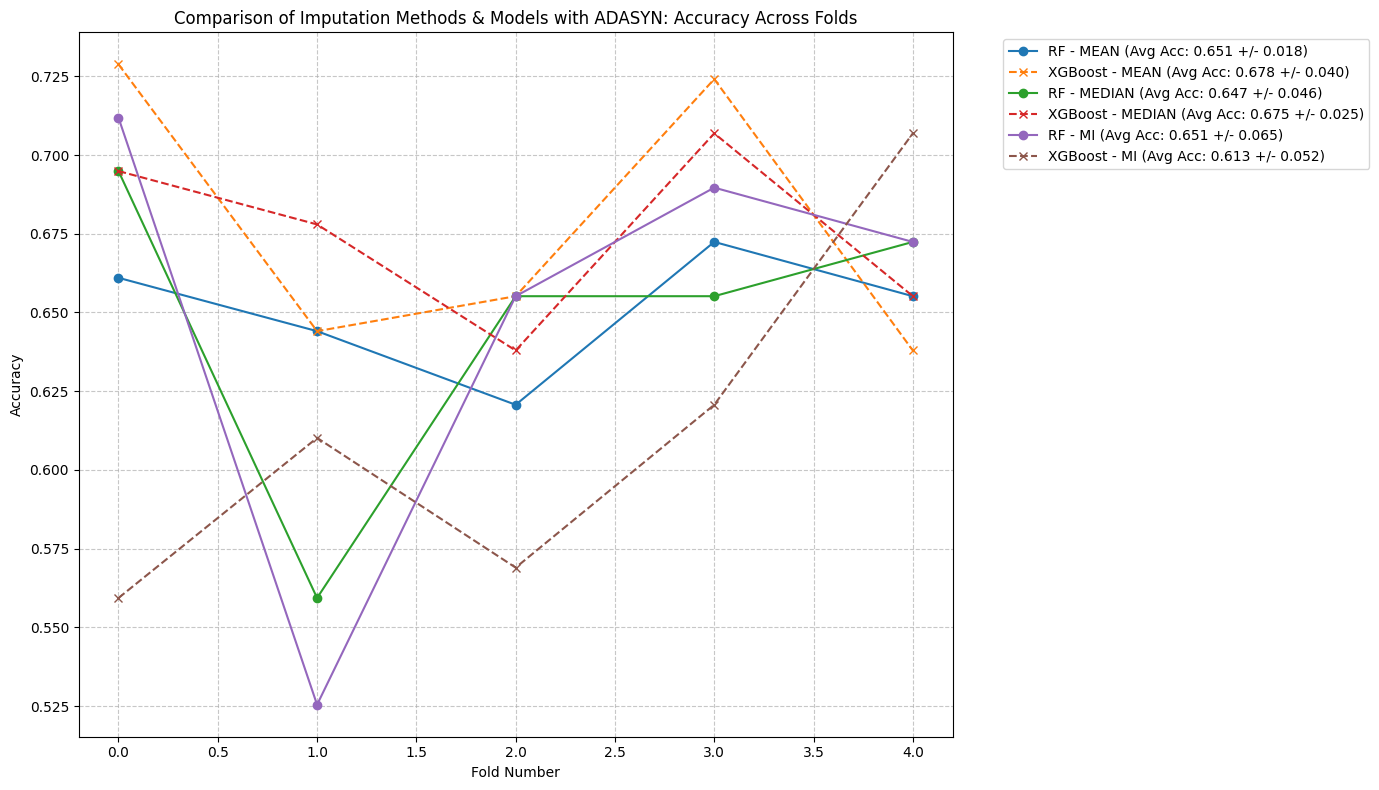

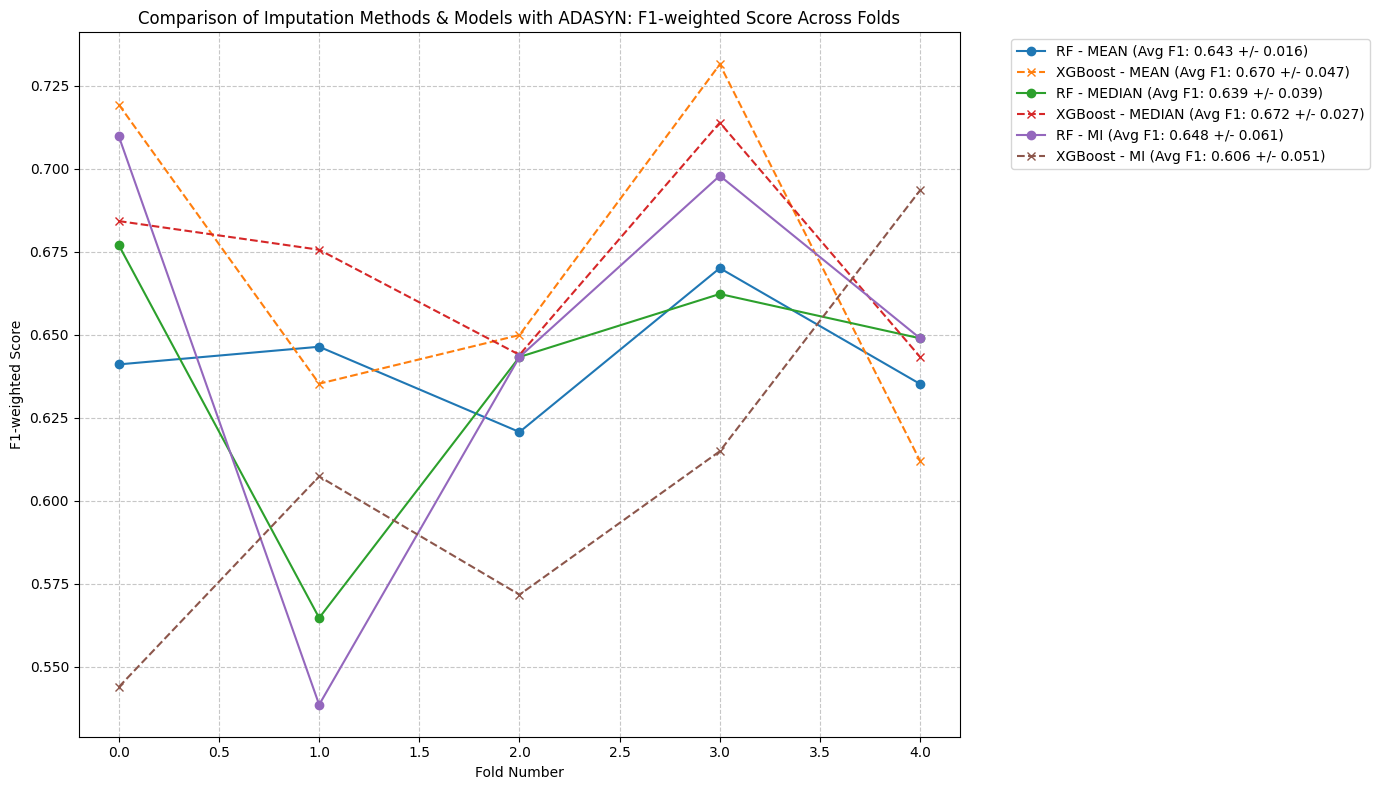


--- SHAP Plots for Best RF and XGBoost Models with ADASYN ---

SHAP Summary Plot for the Best Random Forest (MI Imputation, F1: 0.6477):


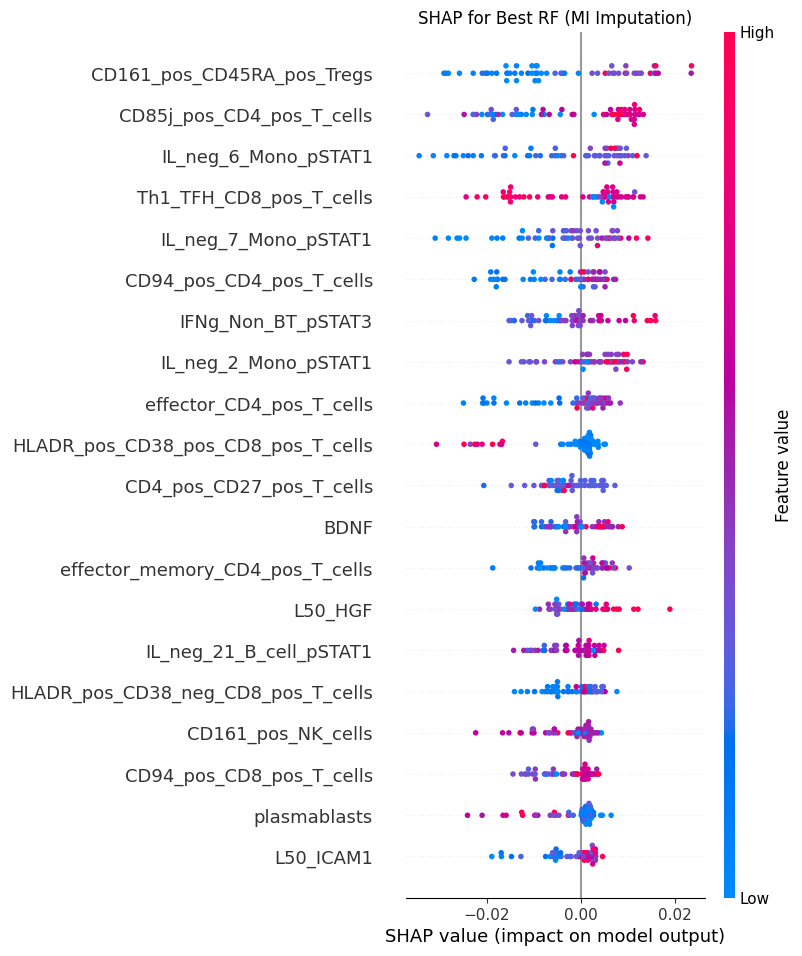


SHAP Summary Plot for the Best XGBoost (MEDIAN Imputation, F1: 0.6722):


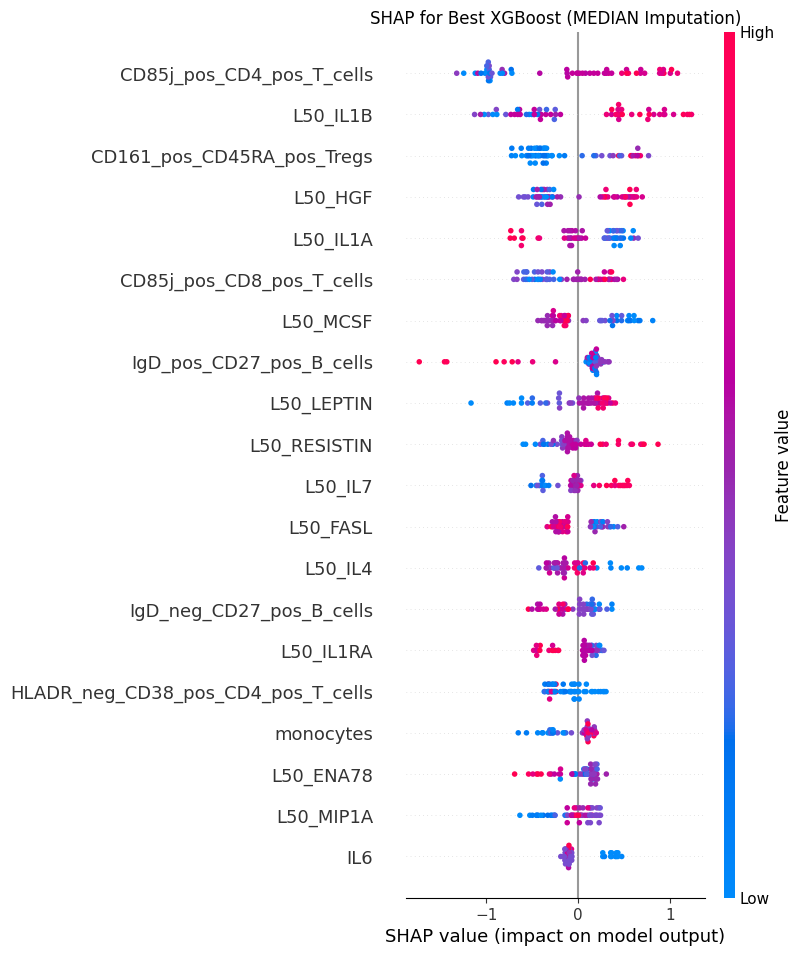

In [ ]:
# --- Cross-Validation Summary ---
print("\n" + "="*40)
print("--- Cross-Validation Summary (with ADASYN) ---")
print("="*40)

for strategy, model_results in adasyn_results.items():
    print(f"\n--- Imputation Method: {strategy.upper()} ---")
    print(f"  Random Forest Average F1-weighted: {np.mean(model_results["rf_f1_weighted"]):.4f} +/- {np.std(model_results["rf_f1_weighted"]):.4f}")
    print(f"  XGBoost Average F1-weighted: {np.mean(model_results["xgb_f1_weighted"]):.4f} +/- {np.std(model_results["xgb_f1_weighted"]):.4f}")

# --- Plotting ---
print("\n--- Generating Comparison Plots (Accuracy & F1-weighted) ---")

# Plot 1: Accuracy Comparison
plt.figure(figsize=(14, 8))
imputation_strategies = list(adasyn_results.keys())
for method in imputation_strategies:
    plt.plot(adasyn_results[method]["rf_accuracies"], marker="o", linestyle="-",
             label=f"RF - {method.upper()} (Avg Acc: {np.mean(adasyn_results[method]["rf_accuracies"]):.3f} +/- {np.std(adasyn_results[method]["rf_accuracies"]):.3f})")
    plt.plot(adasyn_results[method]["xgb_accuracies"], marker="x", linestyle="--",
             label=f"XGBoost - {method.upper()} (Avg Acc: {np.mean(adasyn_results[method]["xgb_accuracies"]):.3f} +/- {np.std(adasyn_results[method]["xgb_accuracies"]):.3f})")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Imputation Methods & Models with ADASYN: Accuracy Across Folds")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: F1-weighted Comparison
plt.figure(figsize=(14, 8))
for method in imputation_strategies:
    plt.plot(adasyn_results[method]["rf_f1_weighted"], marker="o", linestyle="-",
             label=f"RF - {method.upper()} (Avg F1: {np.mean(adasyn_results[method]["rf_f1_weighted"]):.3f} +/- {np.std(adasyn_results[method]["rf_f1_weighted"]):.3f})")
    plt.plot(adasyn_results[method]["xgb_f1_weighted"], marker="x", linestyle="--",
             label=f"XGBoost - {method.upper()} (Avg F1: {np.mean(adasyn_results[method]["xgb_f1_weighted"]):.3f} +/- {np.std(adasyn_results[method]["xgb_f1_weighted"]):.3f})")
plt.xlabel("Fold Number")
plt.ylabel("F1-weighted Score")
plt.title("Comparison of Imputation Methods & Models with ADASYN: F1-weighted Score Across Folds")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- SHAP Plots ---
print("\n" + "="*40)
print(f"--- SHAP Plots for Best RF and XGBoost Models with ADASYN ---")
print("="*40)

# RF SHAP plot
if best_rf_shap_data["rf_values"] is not None:
    print(f"\nSHAP Summary Plot for the Best Random Forest ({best_rf_shap_data["strategy"].upper()} Imputation, F1: {best_rf_f1_score:.4f}):")
    # For multiclass, SHAP values are a list or 3D array; we typically want the values for the positive class (class 1)
    if isinstance(best_rf_shap_data["rf_values"], list):
        shap_values_rf_for_plot = best_rf_shap_data["rf_values"][1]
    else:
        shap_values_rf_for_plot = best_rf_shap_data["rf_values"][:, :, 1]
    
    shap.summary_plot(shap_values_rf_for_plot, best_rf_shap_data["X_test"], show=False)
    plt.title(f"SHAP for Best RF ({best_rf_shap_data["strategy"].upper()} Imputation)")
    plt.show()
else:
    print("SHAP values for the best RF model were not collected.")

# XGB SHAP plot
if best_xgb_shap_data["xgb_values"] is not None:
    print(f"\nSHAP Summary Plot for the Best XGBoost ({best_xgb_shap_data["strategy"].upper()} Imputation, F1: {best_xgb_f1_score:.4f}):")
    shap_values_xgb = best_xgb_shap_data["xgb_values"]
    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
        shap_values_xgb_for_plot = shap_values_xgb[1]
    elif isinstance(shap_values_xgb, np.ndarray) and shap_values_xgb.ndim == 3:
        shap_values_xgb_for_plot = shap_values_xgb[:, :, 1]
    else:
        shap_values_xgb_for_plot = shap_values_xgb
    
    shap.summary_plot(shap_values_xgb_for_plot, best_xgb_shap_data["X_test"], show=False)
    plt.title(f"SHAP for Best XGBoost ({best_xgb_shap_data["strategy"].upper()} Imputation)")
    plt.show()
else:
    print("SHAP values for the best XGBoost model were not collected.")

## Step 6: Additional Evaluation on Final Fold

This step was a bit different compared to prior workflow. Since the best performing RF model included MI, which also happened to the be the pipelne requiring the most computational time, we decided to compute the matrices, ROC-AUC and log-loss all in one, so that the pipeline does not re-run 3 times.

- The best models are retrained on the last fold for detailed evaluation.
- Confusion matrices visualise the distribution of true vs. predicted classes for Random Forest and XGBoost.
- ROC curves with AUC scores summarise classification trade-offs between sensitivity and specificity.
- Log-loss scores assess probabilistic prediction calibration.

---


--- Running Fold 1/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess


--- Running Fold 2/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Running Fold 3/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Running Fold 4/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Running Fold 5/5 ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- Final Cross-Validation Results (Averaged over 5 folds) ---
Random Forest AUC-ROC: 0.6713 ± 0.0889
Random Forest Log Loss: 0.6250 ± 0.0739
--------------------------------------------------
XGBoost AUC-ROC: 0.6615 ± 0.0455
XGBoost Log Loss: 0.8472 ± 0.1456

--- Generating Plots for the Final Fold for Visualization ---


C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


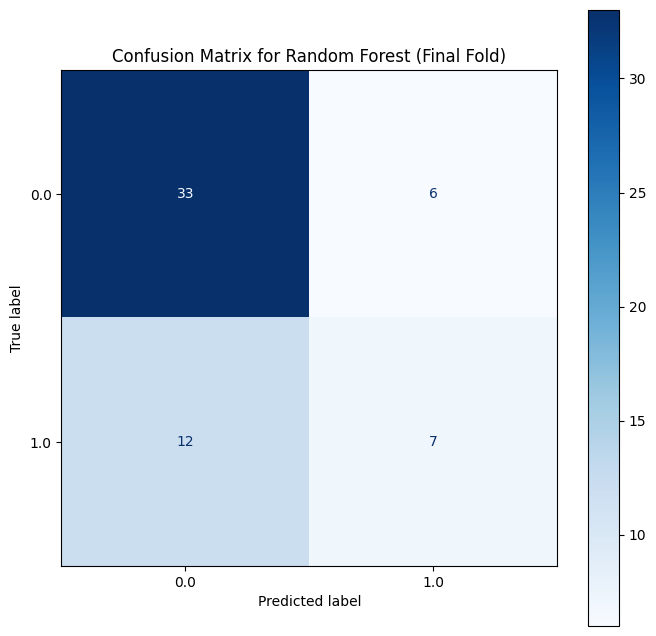

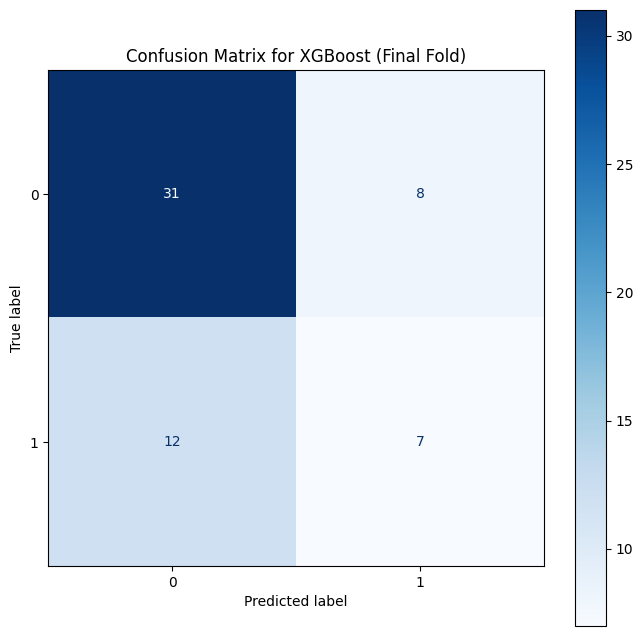

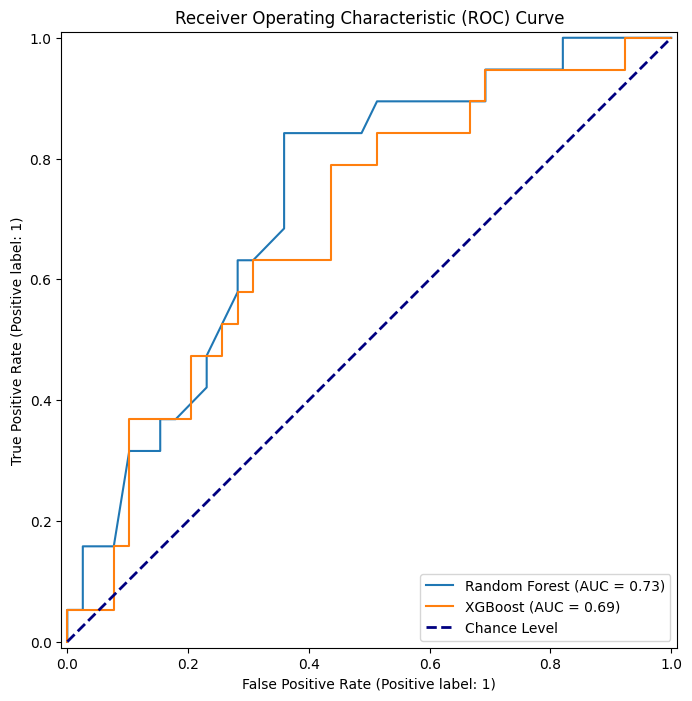

In [ ]:
# --- Define Pipelines for Imputation with ADASYN ---
adasyn_pipelines = {
    "MI_rf": ImbPipeline([
        ("imputer", IterativeImputer(random_state=42)),
        ("scaler", StandardScaler()),
        ("adasyn", ADASYN(random_state=42, sampling_strategy="auto")),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "median_xgb": ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("adasyn", ADASYN(random_state=42, sampling_strategy="auto")),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Store results for each fold ---
rf_auc_scores = []
rf_log_loss_scores = []
xgb_auc_scores = []
xgb_log_loss_scores = []

# --- Main loop to perform 5-fold cross-validation ---
for fold, (train_index, test_index) in enumerate(skf.split(X_filtered, y)):
    print(f"\n--- Running Fold {fold + 1}/{n_splits} ---")
    X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # --- Evaluate RF model on the current fold ---
    rf_pipeline = adasyn_pipelines["MI_rf"]
    rf_pipeline.fit(X_train, y_train)
    y_pred_rf = rf_pipeline.predict(X_test)
    y_proba_rf = rf_pipeline.predict_proba(X_test)
    
    auc_rf = roc_auc_score(y_test, y_proba_rf[:, 1])
    rf_auc_scores.append(auc_rf)
    logloss_rf = log_loss(y_test, y_proba_rf)
    
    rf_auc_scores.append(auc_rf)
    rf_log_loss_scores.append(logloss_rf)

    # --- Evaluate XGBoost model on the current fold ---
    xgb_pipeline = adasyn_pipelines["median_xgb"]
    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)
    y_proba_xgb = xgb_pipeline.predict_proba(X_test)

    auc_xgb = roc_auc_score(y_test, y_proba_xgb[:, 1])
    xgb_auc_scores.append(auc_xgb)
    logloss_xgb = log_loss(y_test, y_proba_xgb)

    xgb_auc_scores.append(auc_xgb)
    xgb_log_loss_scores.append(logloss_xgb)

# --- Print Final Cross-Validation Results ---
print("\n--- Final Cross-Validation Results (Averaged over 5 folds) ---")
print(f"Random Forest AUC-ROC: {np.mean(rf_auc_scores):.4f} ± {np.std(rf_auc_scores):.4f}")
print(f"Random Forest Log Loss: {np.mean(rf_log_loss_scores):.4f} ± {np.std(rf_log_loss_scores):.4f}")
print("-" * 50)
print(f"XGBoost AUC-ROC: {np.mean(xgb_auc_scores):.4f} ± {np.std(xgb_auc_scores):.4f}")
print(f"XGBoost Log Loss: {np.mean(xgb_log_loss_scores):.4f} ± {np.std(xgb_log_loss_scores):.4f}")

# --- Plotting the Confusion Matrices and ROC Curves for the Final Fold ---
# To provide a visual representation, we will retrain on the final fold for plotting.
print("\n--- Generating Plots for the Final Fold for Visualisation ---")
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# Retrain RF pipeline on final fold
rf_pipeline.fit(X_train_final, y_train_final)
y_pred_rf = rf_pipeline.predict(X_test_final)

# Plot Confusion Matrix for RF
cm_rf = confusion_matrix(y_test_final, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Random Forest (Final Fold)")
plt.show()

# Retrain XGBoost pipeline on final fold
xgb_pipeline.fit(X_train_final, y_train_final)
y_pred_xgb = xgb_pipeline.predict(X_test_final)

# Plot Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test_final, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for XGBoost (Final Fold)")
plt.show()

# Plot ROC Curves
plt.figure(figsize=(10, 8))
ax = plt.gca()
RocCurveDisplay.from_estimator(rf_pipeline, X_test_final, y_test_final, ax=ax, name="Random Forest")
RocCurveDisplay.from_estimator(xgb_pipeline, X_test_final, y_test_final, ax=ax, name="XGBoost")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance Level")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()